In [3]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")


Imports done


In [12]:
#script 1
import numpy as np
from statistics import mean, variance, pstdev
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 450 + dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points



def g_gp(x):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2



#initate arrays
mu_x = np.zeros(N)
e_x = np.zeros(N)
e_y = np.zeros(N)
y =np.zeros(N)
x = np.ones(N)*30


omega_x = np.zeros(N)
omega_y = np.zeros(N)
sigma_x = np.zeros(N)
sigma_y = np.zeros(N)
std = np.zeros(N)


omega_x[0] = 5
omega_y[0] = 5 
mu_v = 30
mu_x[0]= 25
std_noise_x = 0.5
std_noise_y = 0.5

alpha_x = 1
alpha_y = 1

alpha_mux = 1
dmuxvec= [0]

for i in np.arange(0,N-1):
   # x = x + np.random.randn(1)*std_noise
    
    # prior real depth: x == prior: mu_v == 30
    x[i] = mu_v         # + np.random.randn(1)*std_noise_x       #x[i+1]  gebruiken
    y[i] = g_gp(x[i])    + np.random.randn(1)*std_noise_y *np.sin(10*1/N*i)

    sigma_x[i] =  1/omega_x[i]
    sigma_y[i] =  1/omega_y[i]
    
    e_x[i] = mu_x[i] - mu_v    # Mu_x[0] = 25 and mu_v = 30 
    e_y[i] = y[i] - g_gp(mu_x[i]) # x = 30 so y(i) = g(30)

    # hidden stsate update
    dFdmu_x = e_x[i]*omega_x[i] - dg_gp(mu_x[i]) * e_y[i]*omega_y[i]
    dmu_x   = 0 - alpha_mux* dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x


    #precision update
    domega_x = alpha_x*(0.5*(1/omega_x[i] - e_x[i]**2))
    domega_y = alpha_y*(0.5*(1/omega_y[i] - e_y[i]**2))
    omega_x[i+1] = omega_x[i] + dt*domega_x
    omega_y[i+1] = omega_y[i] + dt*domega_y

   
    sigma_x[i+1] =1/ omega_x[i+1]
    sigma_y[i+1] =1/ omega_y[i+1]

Text(0.5, 1.0, 'Sigma')

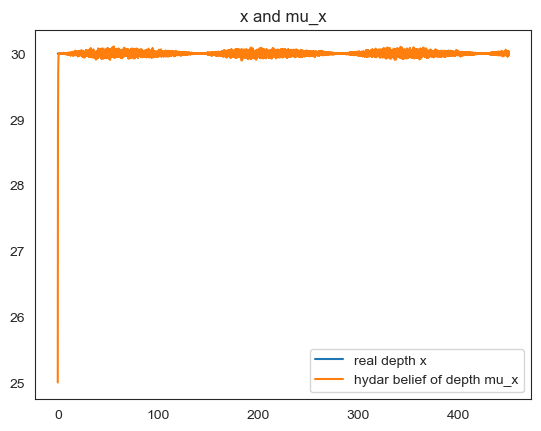

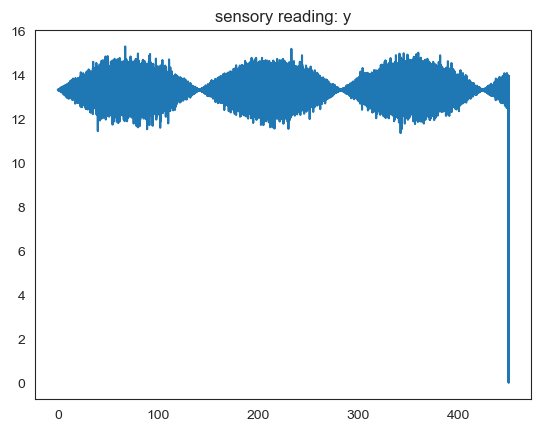

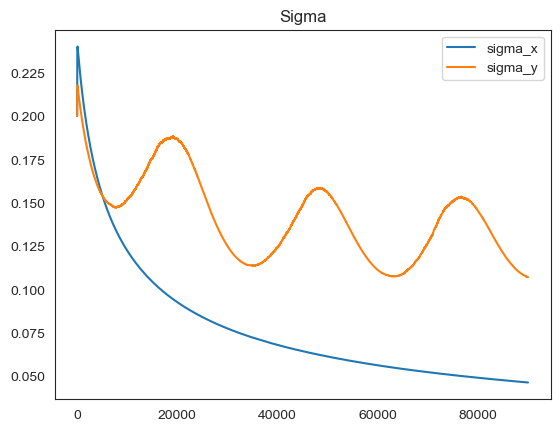

In [13]:
plt.figure()
plt.plot(t, x, label = "real depth x")
plt.plot(t, mu_x, label = "hydar belief of depth mu_x")
plt.title("x and mu_x")
plt.legend()

plt.figure()
plt.plot(t, y)
plt.title("sensory reading: y")
plt.figure()
plt.plot(sigma_x, label= "sigma_x")
plt.plot(sigma_y, label = "sigma_y")
plt.legend()
plt.title("Sigma")

In [7]:
np.mean(sigma_y[15000:20000])

0.24680848101415023

0.031545141841706176
0.0447966730725129


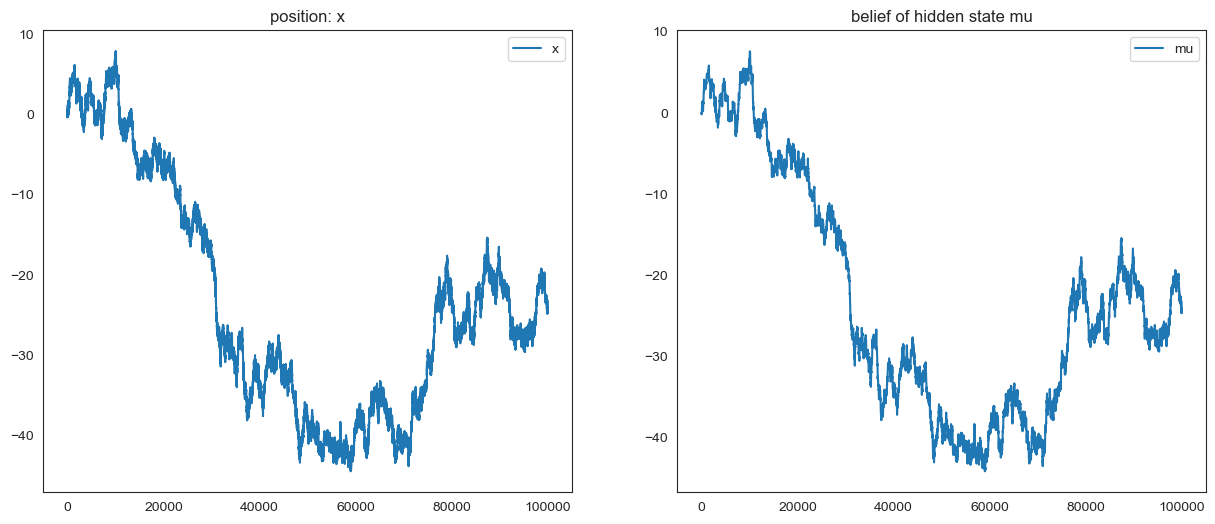

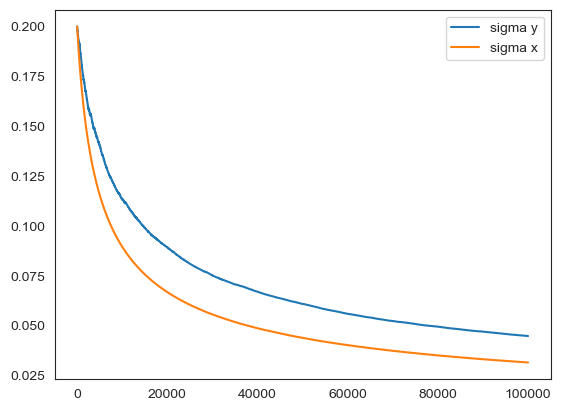

In [7]:
#script 2
import numpy as np
import matplotlib.pyplot as plt

T = 100000


y = np.zeros(T)
x = np.zeros(T)
e = np.zeros(T)
mu = np.zeros(T)

omega = np.zeros(T)
omega_x = np.zeros(T)
omega_y = np.zeros(T)
omega[0] = 1
omega_x[0] = 5
omega_y[0] = 5

alpha = 0.1

alpha_mu = 0.01
alpha_x =  0.01
alpha_y =  0.01



#generative process
for i in np.arange(0,T-1):
    x[i+1] = x[i]   + np.random.randn(1) * 0.1
    y[i]   = x[i]  # + np.random.randn(1) * 0.5
    
    
    e = x[i] - x[i-1]
    domega= 0.5*(1/omega[i] - e**2)
    omega[i+1] = omega[i] +  alpha*domega

mu[0] = x[0]


for i in np.arange(0,T-1):
  
    #prediction errors 
    e_x = mu[i] - mu[i-1] 
    e_y = y[i] - mu[i]

    
    dFdmu =  -1*omega_y[i]*e_y #-1*omega_x[i]*e_x  #weet niet zo goed hoe ik dit moet afleiden. 
    dmu   = 0 - alpha_mu* dFdmu
    mu[i+1] = mu[i] + dmu
    
    domega_x = 0.5*(1/omega_x[i] - e_x**2)
    domega_y = 0.5*(1/omega_y[i] - e_y**2)
    omega_x[i+1] = omega_x[i] +  alpha_x*domega_x
    omega_y[i+1] = omega_y[i] +  alpha_y*domega_y




plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(x, label = "x")
plt.title("position: x")
plt.legend()

plt.subplot(1,2,2)
plt.plot(mu, label = "mu")
plt.title("belief of hidden state mu")
plt.legend()


plt.figure()
plt.plot(1/omega_y, label = "sigma y")
plt.plot(1/omega_x, label = "sigma x")
plt.legend()

print(1/omega_x[-1])
print(1/omega_y[-1])

# plt.figure()
# plt.plot(1/omega)


In [8]:
#script 3
import numpy as np
import matplotlib.pyplot as plt

# Define time settings
T = 2000
dt = 0.01
time = np.arange(0, T, dt)
decay = 0.999

# Generative process parameters
A_true = np.array([[1, dt],  # State dynamics
                   [0, decay]])  # Velocity dynamics

# Process noise
Q_true = np.array([[0, 0],
                   [0,   0 ]])

# Generate true states: position and velocity
x_gen = np.zeros((2, len(time)))
x_gen[:, 0] = [0, 1]  # Initial position and velocity

for t in range(1, len(time)):
    noise = np.random.multivariate_normal([0, 0], Q_true)
    x_gen[:, t] = np.dot(A_true, x_gen[:, t-1]) + noise

# Generate observations with sensory noise
H_true = np.array([1, 0])  # Observe position only
R_true = 0.2
y_obs = np.dot(H_true, x_gen) + np.sqrt(R_true) * np.random.randn(len(time))

# Generative model parameters
A = np.array([[1, dt],
              [0, 1]])
H = np.array([1, 0])

# Initial beliefs about states and uncertainties
mu = np.zeros((2, len(time)))
mu[:, 0] = [0, 0]
Sigma = np.array([[1, 0],
                  [0, 1]])

# Initial beliefs about process and sensory noise precisions (inverse variances)
alpha_process = 5  # Precision belief for process noise
alpha_sensory = 5  # Precision belief for sensory noise
learning_rate = 0.1

# Storage for estimated precisions (inverse variances)
alpha_process_belief = np.zeros(len(time))
alpha_sensory_belief = np.zeros(len(time))



mu_dot = 1
for t in range(1, len(time)):
    mu_prior = mu[:,t-1]
    
    mu_dot = decay*mu_dot
    mu_model = [mu_dot,0]              #velocity = 1

    D = np.array([[0,1], [0,0]])

    
    e_x = mu[:, t-1] - mu[:, t-2]
    #e_x = D.dot(mu_prior) - mu_dot 
    e_y = y_obs[t-1] - np.dot(H, mu_prior)

    dFdmu = -1*alpha_sensory*(e_y)  #+- alpha_process*(e_x)
    dmu = np.dot(D,mu_prior) - 1*dFdmu
    mu[:,t] = mu[:,t-1] + 15*dt*dmu


    alpha_process += learning_rate*dt*(1/alpha_process -e_x[0]**2)
    alpha_sensory += learning_rate*dt*(1/alpha_sensory -e_y**2)

    alpha_process_belief[t] = alpha_process
    alpha_sensory_belief[t] = alpha_sensory





C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_17208\1245672338.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.plot(time, 1/alpha_process_belief)
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_17208\1245672338.py:29: RuntimeWarning: divide by zero encountered in divide
  plt.plot(time, 1/alpha_sensory_belief)


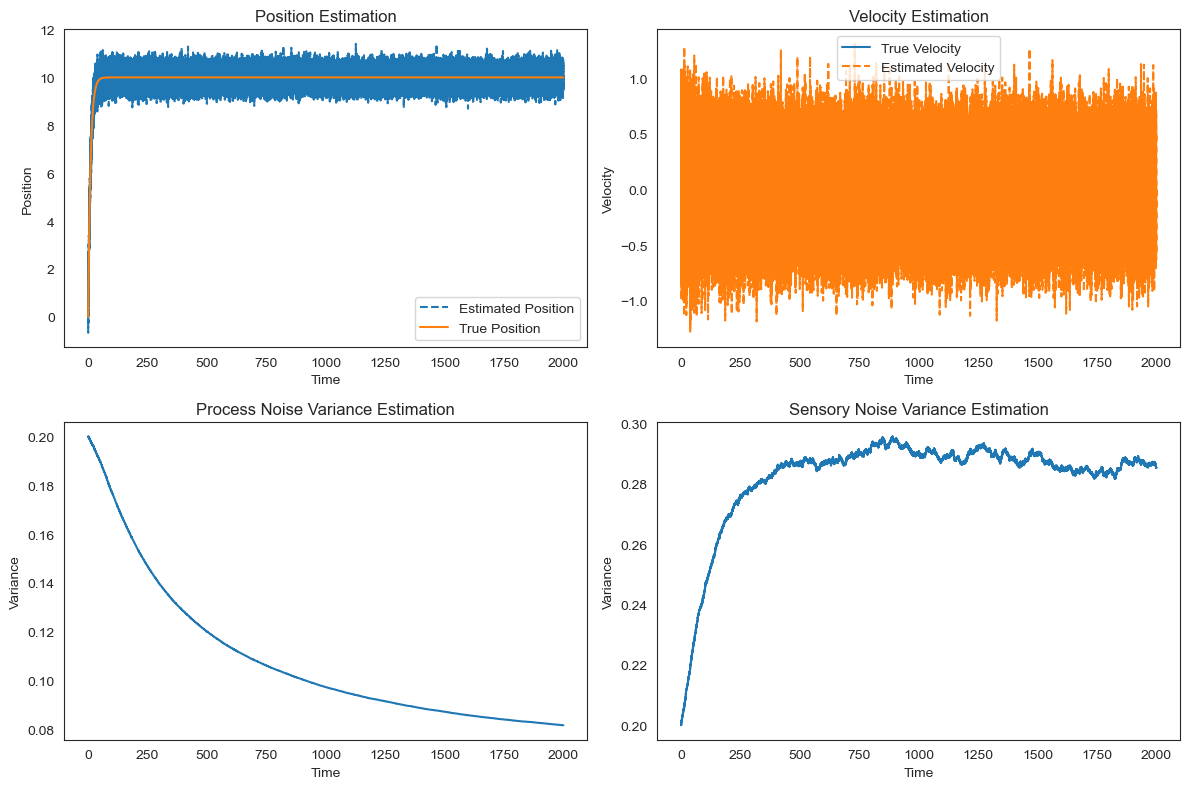

In [9]:
# print(np.mean(1/alpha_sensory_belief[19000:20000]))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)

plt.plot(time, mu[0, :], label='Estimated Position', linestyle='dashed')
plt.plot(time, x_gen[0, :], label='True Position')
plt.legend()
plt.title('Position Estimation')
plt.xlabel('Time')
plt.ylabel('Position')

plt.subplot(2, 2, 2)
plt.plot(time, x_gen[1, :], label='True Velocity')
plt.plot(time, mu[1, :], label='Estimated Velocity', linestyle='dashed')
plt.legend()
plt.title('Velocity Estimation')
plt.xlabel('Time')
plt.ylabel('Velocity')

plt.subplot(2, 2, 3)
plt.plot(time, 1/alpha_process_belief)
plt.title('Process Noise Variance Estimation')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.subplot(2, 2, 4)
plt.plot(time, 1/alpha_sensory_belief)
plt.title('Sensory Noise Variance Estimation')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()

In [74]:
#script 4
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv

# Define time settings
T = 10
dt = 0.005
time = np.arange(0, T, dt)
N  = time.size

x = np.zeros(N)
x_dot = np.zeros(N)
y = np.zeros(N)
y_dot = np.zeros(N)
mu = np.zeros(N)
mu_dot = np.zeros(N)
omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

omega_w0[0] = 5
omega_w1[0] = 5
omega_z0[0] = 5
omega_z1[0] = 5

alpha_mu = 1


x[0] = 0
y[0] = 0
D = np.array([[0,1],[0,0]])

#Generative process
for i in np.arange(0,N-1):

    x_dot[i] = -x[i] + 30   #np.random.randn(1)*0.5
    
    x[i+1] = x[i] + dt*x_dot[i]

    y[i] = x[i] + np.random.randn(1)*0.3
    y_dot[i] = x_dot[i] #+np.random.randn(1)*0.5
    



for i in np.arange(0,N-1):
    
    #use these form gp: xdot = 1
    # dFdmu = np.dot(np.identity(2),np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    #e_x = np.array([[mu_dot[i]], [0]]) - np.array([[1],[0]])



    # PI_w = np.diag([omega_w0[i],omega_w1[i]])
    # PI_z = np.diag([omega_z0[i],omega_z1[i]])

    PI_w = np.diag([1,1])
    PI_z = np.diag([1,1])
    
    e_x = np.array([[mu_dot[i]], [0]]) - (np.array([[-mu[i]],[mu_dot[i]]])+np.array([[30],[0]]))
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu[i]],[mu_dot[i]]])
    # e_y = np.array([[y[i]],[0]]) - np.array([[mu[i]],[mu_dot[i]]])

    
    dFdmu = np.dot(np.array([[1,1],[0,0]]),np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    dmu = np.array([[mu_dot[i]], [0]]) - alpha_mu*dFdmu
    
    mu[i+1] = mu[i] + dt*dmu[0]
    mu_dot[i+1] = mu_dot[i] +dt*dmu[1]

     #   precision optimization
    # dPI_w = 0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    # dPI_z = 0.5*(inv(PI_z) - np.diag(e_y.flatten())**2)
    # PI_w = PI_w + dt*dPI_w
    # PI_z = PI_z + dt*dPI_z

    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]




In [66]:
print(dPI_w)

[[ 0.00580044  0.        ]
 [-0.         -0.00235519]]


[ 0.          0.75032325  1.47002164 ... 30.04656347 30.05137711
 30.04962608]
[0.         0.75       1.47422698 ... 0.00172137 0.00171277 0.0017042 ]


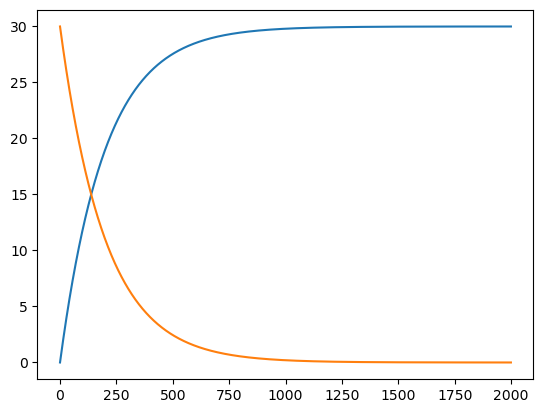

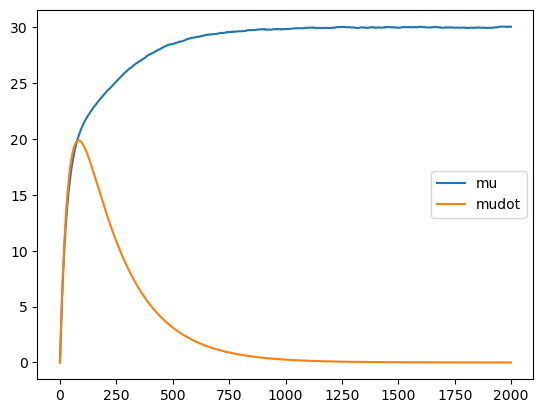

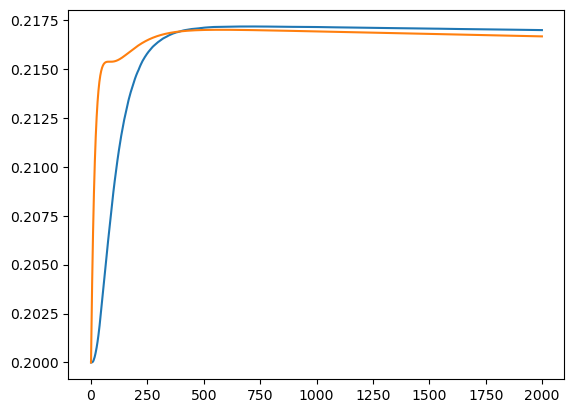

In [72]:
print(mu)
print(mu_dot)

plt.figure()
plt.plot(x)
plt.plot(x_dot)
# plt.plot(mu_dot)

plt.figure()
plt.plot(mu, label = "mu")
plt.plot(mu_dot, label = "mudot")
plt.legend()

# plt.figure()
# plt.plot(mu)

plt.figure()
plt.plot(1/omega_z1)
plt.plot(1/omega_z2)

In [32]:

a = np.array([[1],[2]])
b = np.array([[1,2],[3,4]])
print(np.dot(b,a) )
print(np.dot(np.identity(2),np.dot(b,a) ))

print(e_x)
print(np.diag(e_x.flatten()))

[[ 5]
 [11]]
[[ 5.]
 [11.]]
[[0.00299601]
 [0.        ]]
[[0.00299601 0.        ]
 [0.         0.        ]]
